In [1]:
import pandas as pd

data = pd.read_csv('data/^NDX_raw_data.csv')
data.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data_backup = data.iloc[3524:]

data = data.iloc[:3524]
data_copy = data.copy()

print('Data imported and copied.', flush=True)

Data imported and copied.


In [2]:
import numpy as np

## Creating sequences
def create_dataset(dataset, time_step=1, output_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-output_step):
        a = dataset[i:(i+time_step), 0]
        b = dataset[(i+time_step):(i+time_step)+output_step, 0]
        dataX.append(a)
        dataY.append(b)

    return np.array(dataX), np.array(dataY)

period = 60
trend_period = 14
rsi_period = 14
num_features = 3
input_period = 46
output_step = 7
units = 512

In [3]:
X, y = create_dataset(data[['close']].to_numpy(), time_step=period, output_step=output_step)

In [4]:
data_input = np.array([np.concatenate((X[i], y[i]), axis=0) for i in range(X.shape[0])])

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompositions = np.array([seasonal_decompose(data_input[i], model='additive', period=14) for i in range(data_input.shape[0])])
seasons = np.array([decompositions[i].seasonal for i in range(decompositions.shape[0])])

In [6]:
from talib import RSI

rsi = np.array([ RSI(data_input[i]) for i in range(data_input.shape[0]) ])

In [7]:
from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter
window_length = 11  # Window length (must be odd)
polyorder = 2      # Polynomial order

savgol = np.array([ savgol_filter(data_input[i], window_length, polyorder) for i in range(data_input.shape[0]) ])

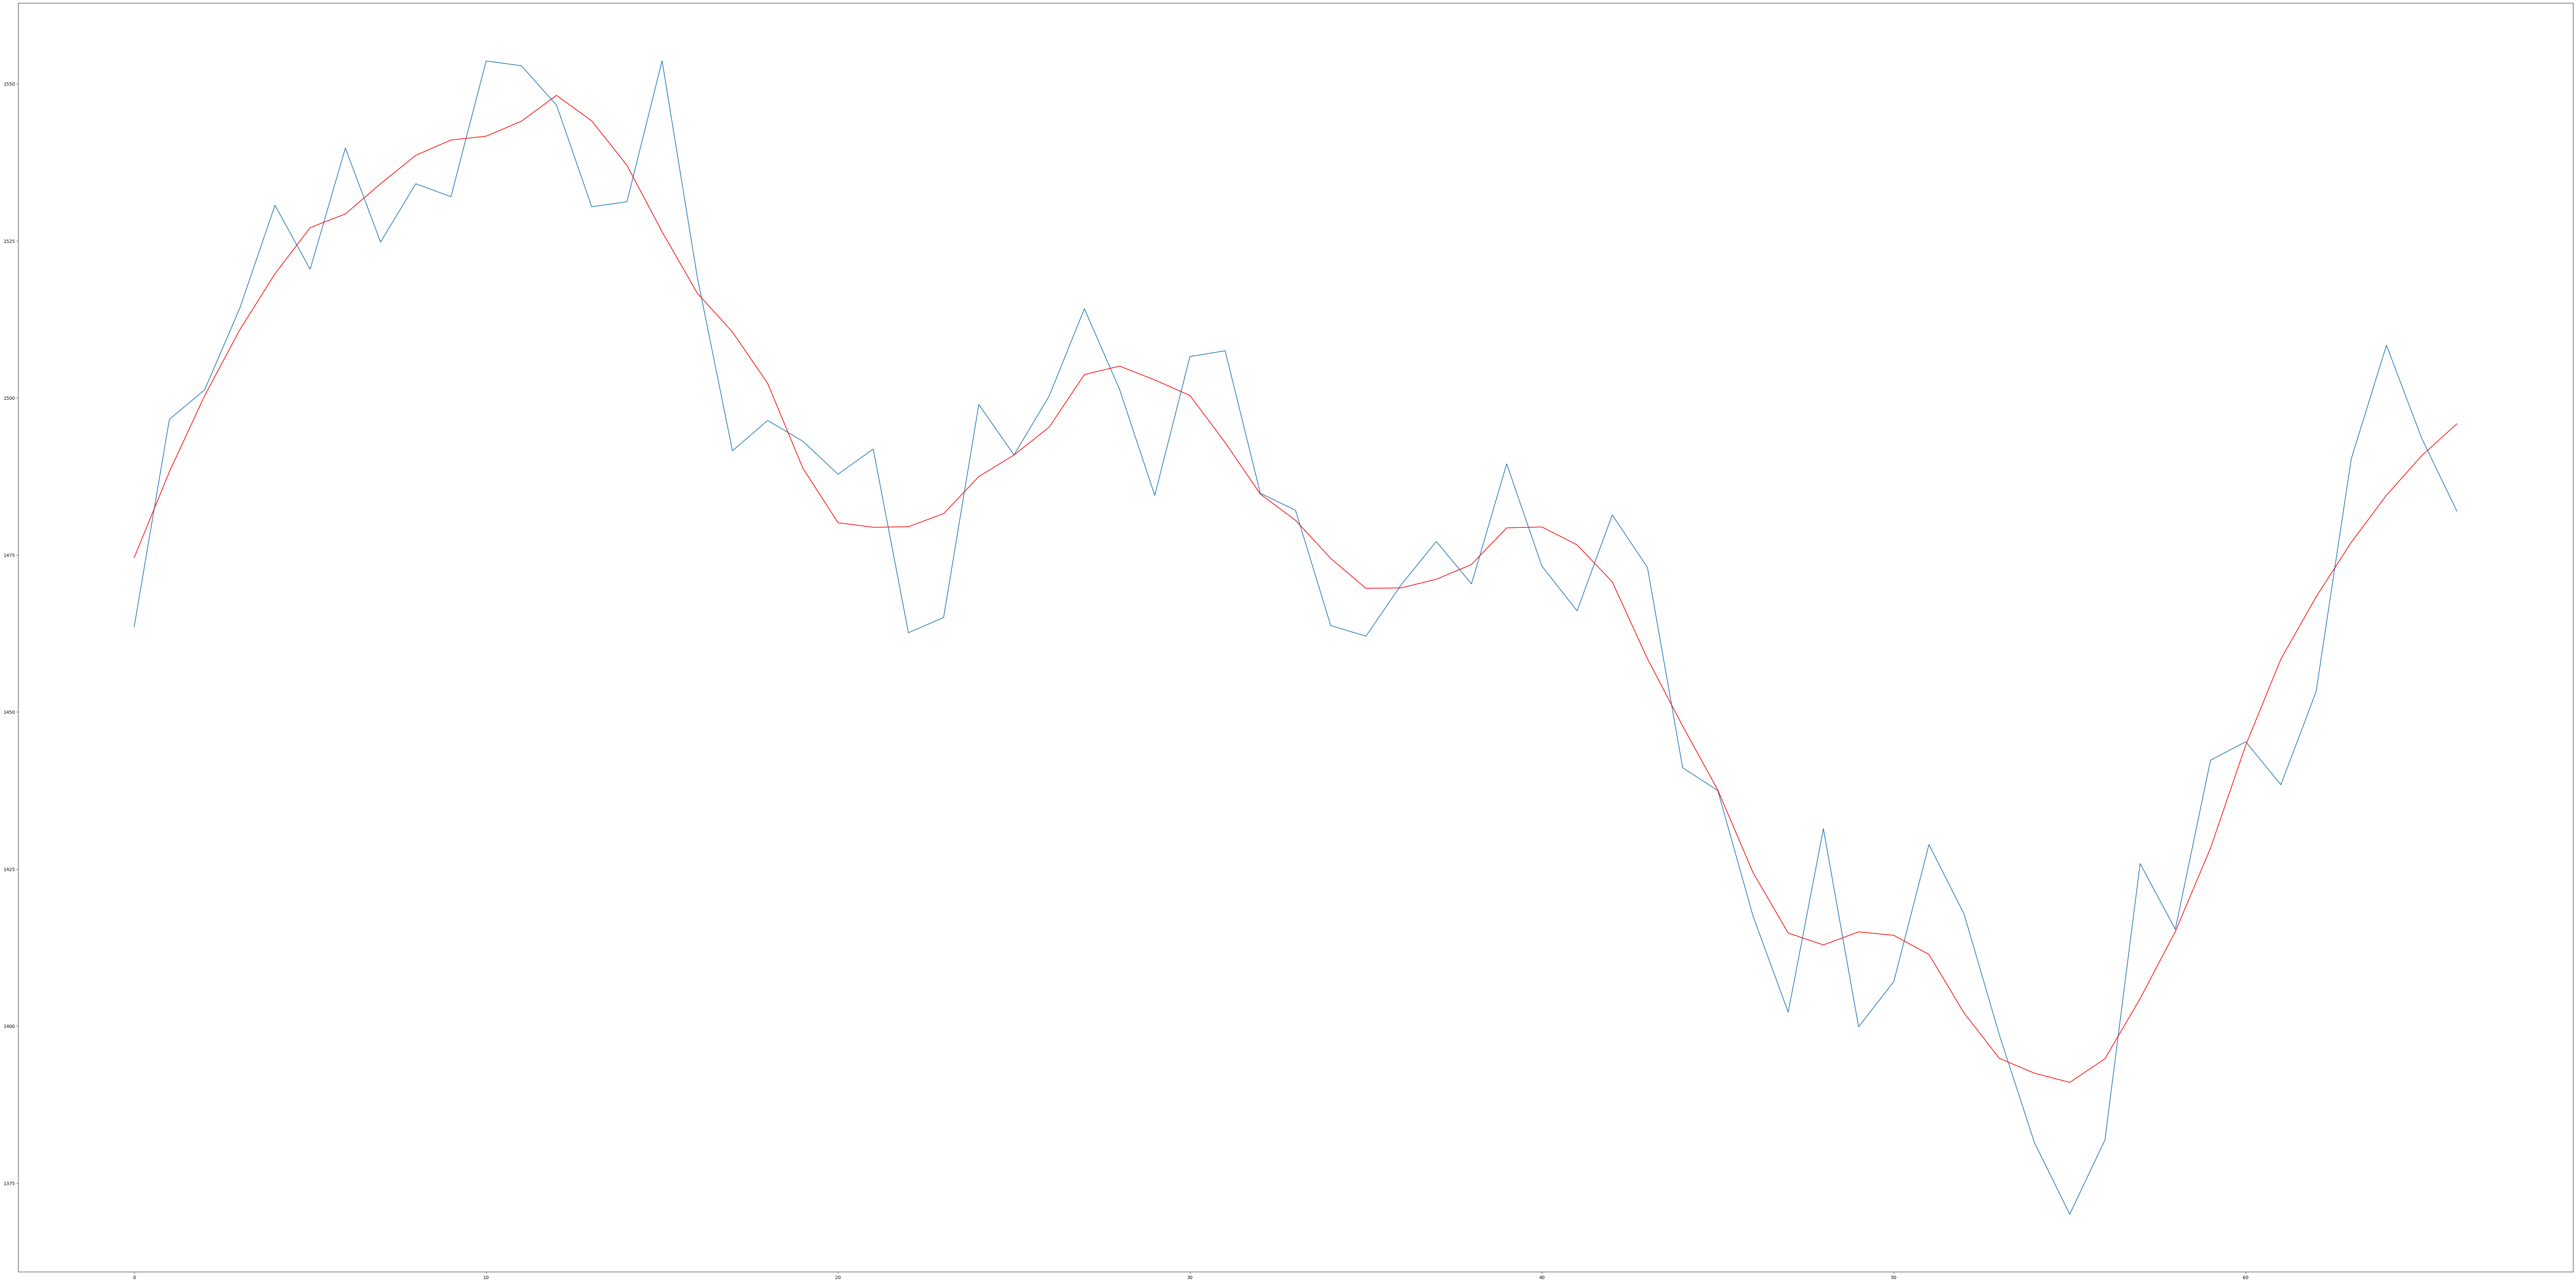

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 50))

plt.plot(data_input[0], label='Original Data')
plt.plot(savgol[0], label='SavGol Smoothing', color='red')

In [9]:
savgol_cropped = list()
seasons_cropped = list()
rsi_dropna = list()

for _savgol in savgol:
    savgol_cropped.append(_savgol[rsi_period:])

for _season in seasons:
    seasons_cropped.append(_season[rsi_period:])

for _rsi in rsi:
    rsi_dropna.append(_rsi[rsi_period:])

savgol_cropped = np.array(savgol_cropped)
seasons_cropped = np.array(seasons_cropped)
rsi_dropna = np.array(rsi_dropna)

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler_savgol = list(MinMaxScaler() for i in range(savgol_cropped.shape[0]))
savgol_scaled = list()

scaler_seasonal = list(MinMaxScaler() for i in range(seasons_cropped.shape[0]))
seasons_scaled = list()

scaler_rsi = list(MinMaxScaler() for i in range(rsi_dropna.shape[0]))
rsi_scaled = list()

for i in range(savgol_cropped.shape[0]):
    savgol_scaled.append(scaler_savgol[i].fit_transform(savgol_cropped[i].reshape(-1,1)))

for i in range(seasons_cropped.shape[0]):
    seasons_scaled.append(scaler_seasonal[i].fit_transform(seasons_cropped[i].reshape(-1,1)))

for i in range(rsi_dropna.shape[0]):
    rsi_scaled.append(scaler_rsi[i].fit_transform(rsi_dropna[i].reshape(-1,1)))

savgol_scaled = np.array(savgol_scaled)
seasons_scaled = np.array(seasons_scaled)
rsi_scaled = np.array(rsi_scaled)

In [11]:
X_input = list()
y_input = list()

for savgol, season, rsi in zip(savgol_scaled, seasons_scaled, rsi_scaled):
    X_input.append(np.hstack((savgol[:-y.shape[1]], season[:-y.shape[1]], rsi[:-y.shape[1]])))
    y_input.append(savgol[-y.shape[1]:])

X_input = np.array(X_input)
y_input = np.array(y_input)

# Main model

In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Conv1D, AveragePooling1D, Flatten, Reshape, SimpleRNN, GRU, MaxPooling1D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import Zeros

inputs = Input(shape=(input_period, num_features))

model_cnn = Sequential([
    Conv1D(filters=352, kernel_size=1, activation='relu'),
    Conv1D(filters=352, kernel_size=1, activation='relu'),
    MaxPooling1D(pool_size=3),
    Dense(units=128),
    Flatten()
    #Dense(units=output_step),
    #Reshape((output_step,1))
])

model_bilstm = Sequential([
    Bidirectional(LSTM(units=384, return_sequences=True, activation='tanh', recurrent_activation='sigmoid')),
    Dropout(0.2),
    Flatten()
    #Dense(units=output_step),
    #Reshape((output_step,1))
])

model_bigru = Sequential([
    Bidirectional(GRU(units=128, activation='tanh', return_sequences=True)),
    Dropout(0.4),
    Flatten()
])

model_multilayer_lstm = Sequential([
    LSTM(units=64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'),
    Dropout(0.2),
    LSTM(units=64, return_sequences=True, activation='tanh', recurrent_activation='sigmoid'),
    Flatten()
])

2024-06-13 06:09:53.695012: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 06:09:54.055318: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 06:09:54.055503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 06:09:54.117619: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-13 06:09:54.237715: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 06:09:56.424674: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

In [13]:
output_cnn = model_cnn(inputs)
output_bilstm = model_bilstm(inputs)
output_bigru = model_bigru(inputs)
output_multilayer_lstm = model_multilayer_lstm(inputs)

concatenated_outputs = concatenate([output_cnn, output_bilstm, output_bigru, output_multilayer_lstm])

main_model = Sequential([
    Input(shape=(concatenated_outputs.shape[1],)),
    Dense(units=output_step),
    Reshape((output_step,1))
])

final_output = main_model(concatenated_outputs)

functional_pipeline = Model(inputs=inputs, outputs=final_output)

In [14]:
# Compile the pipeline model
functional_pipeline.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='model_weights_6_4_savgol/model_weights_epoch_{epoch:02d}.h5', 
                            save_best_only=True, save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the pipeline model
history = functional_pipeline.fit(X_input, y_input, epochs=150, batch_size=64, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Epoch 1/150


2024-05-29 10:18:35.878611: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9043968 exceeds 10% of free system memory.
2024-05-29 10:18:35.886188: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9043968 exceeds 10% of free system memory.
2024-05-29 10:18:35.913439: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 13303808 exceeds 10% of free system memory.
2024-05-29 10:18:35.922071: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 13303808 exceeds 10% of free system memory.
2024-05-29 10:18:36.039846: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9043968 exceeds 10% of free system memory.


44/44 [==============================] - 75s 1s/step - loss: 0.1341 - accuracy: 0.0645 - val_loss: 0.0401 - val_accuracy: 0.0778
Epoch 2/150
44/44 [==============================] - 50s 1s/step - loss: 0.0404 - accuracy: 0.0755 - val_loss: 0.0318 - val_accuracy: 0.0797
Epoch 3/150
44/44 [==============================] - 46s 1s/step - loss: 0.0311 - accuracy: 0.0765 - val_loss: 0.0267 - val_accuracy: 0.0811
Epoch 4/150
44/44 [==============================] - 45s 1s/step - loss: 0.0266 - accuracy: 0.0777 - val_loss: 0.0253 - val_accuracy: 0.0818
Epoch 5/150
44/44 [==============================] - 45s 1s/step - loss: 0.0241 - accuracy: 0.0782 - val_loss: 0.0249 - val_accuracy: 0.0820
Epoch 6/150
44/44 [==============================] - 53s 1s/step - loss: 0.0244 - accuracy: 0.0782 - val_loss: 0.0258 - val_accuracy: 0.0815
Epoch 7/150
44/44 [==============================] - 48s 1s/step - loss: 0.0218 - accuracy: 0.0787 - val_loss: 0.0238 - val_accuracy: 0.0824
Epoch 8/150
44/44 [======

In [15]:
# Select the epoch
best_epoch = np.argmin(history.history['val_loss'])
best_epoch = best_epoch+1
print(f'best result is for epoch number {best_epoch}')

# Load the weights of the model at the chosen epoch
functional_pipeline.load_weights(f'model_weights_6_4_savgol/model_weights_epoch_{best_epoch:02d}.h5')
print('Weigths for the best epoch has been loaded.')

best result is for epoch number 10
Weigths for the best epoch has been loaded.


In [14]:
best_epoch_backup = 10

# Load the weights of the model at the chosen epoch
functional_pipeline.load_weights(f'model_weights_6_4_savgol/model_weights_epoch_{best_epoch_backup:02d}.h5')
print('Backup: Weigths for the best epoch has been loaded.')

Backup: Weigths for the best epoch has been loaded.


# data testing

In [16]:
#data_backup = pd.read_csv('data/^NDX_raw_data.csv')
data_backup = pd.read_csv('data-china-from2018-test/000001.SS_raw_data.csv')
data_backup.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Volume':'volume'}, inplace=True)

data_backup_copy = data_backup.copy()

In [17]:
X_test, y_test = create_dataset(data_backup[['close']].to_numpy(), time_step=period, output_step=output_step)

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompositions_test = np.array([seasonal_decompose(X_test[i], model='additive', period=14) for i in range(X_test.shape[0])])
seasons_test = np.array([decompositions_test[i].seasonal for i in range(decompositions_test.shape[0])])

In [19]:
from talib import RSI

rsi_test = np.array([ RSI(X_test[i]) for i in range(X_test.shape[0]) ])

In [20]:
from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter
window_length = 11  # Window length (must be odd)
polyorder = 2      # Polynomial order

savgol_test = np.array([ savgol_filter(X_test[i], window_length, polyorder) for i in range(X_test.shape[0]) ])

In [21]:
savgol_cropped_test = list()
seasons_cropped_test = list()
rsi_dropna_test = list()

for _savgol in savgol_test:
    savgol_cropped_test.append(_savgol[rsi_period:])

for _season in seasons_test:
    seasons_cropped_test.append(_season[rsi_period:])

for _rsi in rsi_test:
    rsi_dropna_test.append(_rsi[rsi_period:])

savgol_cropped_test = np.array(savgol_cropped_test)
seasons_cropped_test = np.array(seasons_cropped_test)
rsi_dropna_test = np.array(rsi_dropna_test)

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler_savgol_test = list(MinMaxScaler() for i in range(savgol_cropped_test.shape[0]))
savgol_scaled_test = list()

scaler_seasonal_test = list(MinMaxScaler() for i in range(seasons_cropped_test.shape[0]))
seasons_scaled_test = list()

scaler_rsi_test = list(MinMaxScaler() for i in range(rsi_dropna_test.shape[0]))
rsi_scaled_test = list()

for i in range(savgol_cropped_test.shape[0]):
    savgol_scaled_test.append(scaler_savgol_test[i].fit_transform(savgol_cropped_test[i].reshape(-1,1)))

for i in range(seasons_cropped_test.shape[0]):
    seasons_scaled_test.append(scaler_seasonal_test[i].fit_transform(seasons_cropped_test[i].reshape(-1,1)))

for i in range(rsi_dropna_test.shape[0]):
    rsi_scaled_test.append(scaler_rsi_test[i].fit_transform(rsi_dropna_test[i].reshape(-1,1)))

savgol_scaled_test = np.array(savgol_scaled_test)
seasons_scaled_test = np.array(seasons_scaled_test)
rsi_scaled_test = np.array(rsi_scaled_test)

In [23]:
X_input_test = list()
#y_input = list()

for savgol, season, rsi in zip(savgol_scaled_test, seasons_scaled_test, rsi_scaled_test):
    X_input_test.append(np.hstack((savgol, season, rsi)))
    #y_input.append(lowess[-y.shape[1]:])

X_input_test = np.array(X_input_test)
#y_input = np.array(y_input)

In [30]:
# Prepare reference y_test
test_input = np.array([np.concatenate((X_test[i], y_test[i]), axis=0) for i in range(X_test.shape[0])])

decompose_test_input = np.array([seasonal_decompose(test_input[i], model='additive', period=14) for i in range(X_test.shape[0])])
trends_test_input = np.array([decompose_test_input[i].trend for i in range(decompose_test_input.shape[0])])

trends_test_input_dropna = list()
for trend in trends_test_input:
    trends_test_input_dropna.append(trend[~np.isnan(trend)])

trends_test_input_dropna = np.array(trends_test_input_dropna)

y_input = list()
for trend in trends_test_input_dropna:
    y_input.append(trend[trend.shape[0]-7:])

y_input = np.array(y_input)

In [24]:
savgol_predictions_test = list()

for j in range(X_input_test.shape[0]):
    if (j+1) % 100 == 0:
        print(j+1)
        
    savgol_predictions_test.append(
        scaler_savgol_test[j].inverse_transform(
            functional_pipeline.predict(X_input_test[j].reshape(savgol_scaled_test[j].shape[1], input_period, num_features), verbose=0)[0].reshape(1,output_step)
        )
    )

savgol_predictions_test = np.array(savgol_predictions_test)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500


In [25]:
savgol_predictions_test.shape, data_backup.shape

((1547, 1, 7), (1614, 6))

In [26]:
# Logistic transformation
def logistic_transform(r2):
    return round(1 / (1 + np.exp(-r2)),2)
        
def report_score(outputs):
    from sklearn.metrics import r2_score
    
    pred, y = outputs
    
    try:
        assert pred.shape[2] == output_step
        assert y.shape[1] == output_step

        _pred = pred.reshape(-1, output_step)
        _y = y.reshape(-1, output_step)
    
        res = list()
        for i in range(_pred.shape[0]):
            res.append(r2_score(_y[i], _pred[i]))

        res = np.array(res)
    
        return {
            'mean_score': np.mean(res),
            'max_score': res.max(),
            'min_score': res.min(),
            'logistic_score': logistic_transform(np.mean(res))
        }
    except:
        print("Array shapes don't match")

In [31]:
report_score((savgol_predictions_test, y_input))

{'mean_score': -99.50286077937484,
 'max_score': 0.9434103503308019,
 'min_score': -4856.180003870015,
 'logistic_score': 0.0}

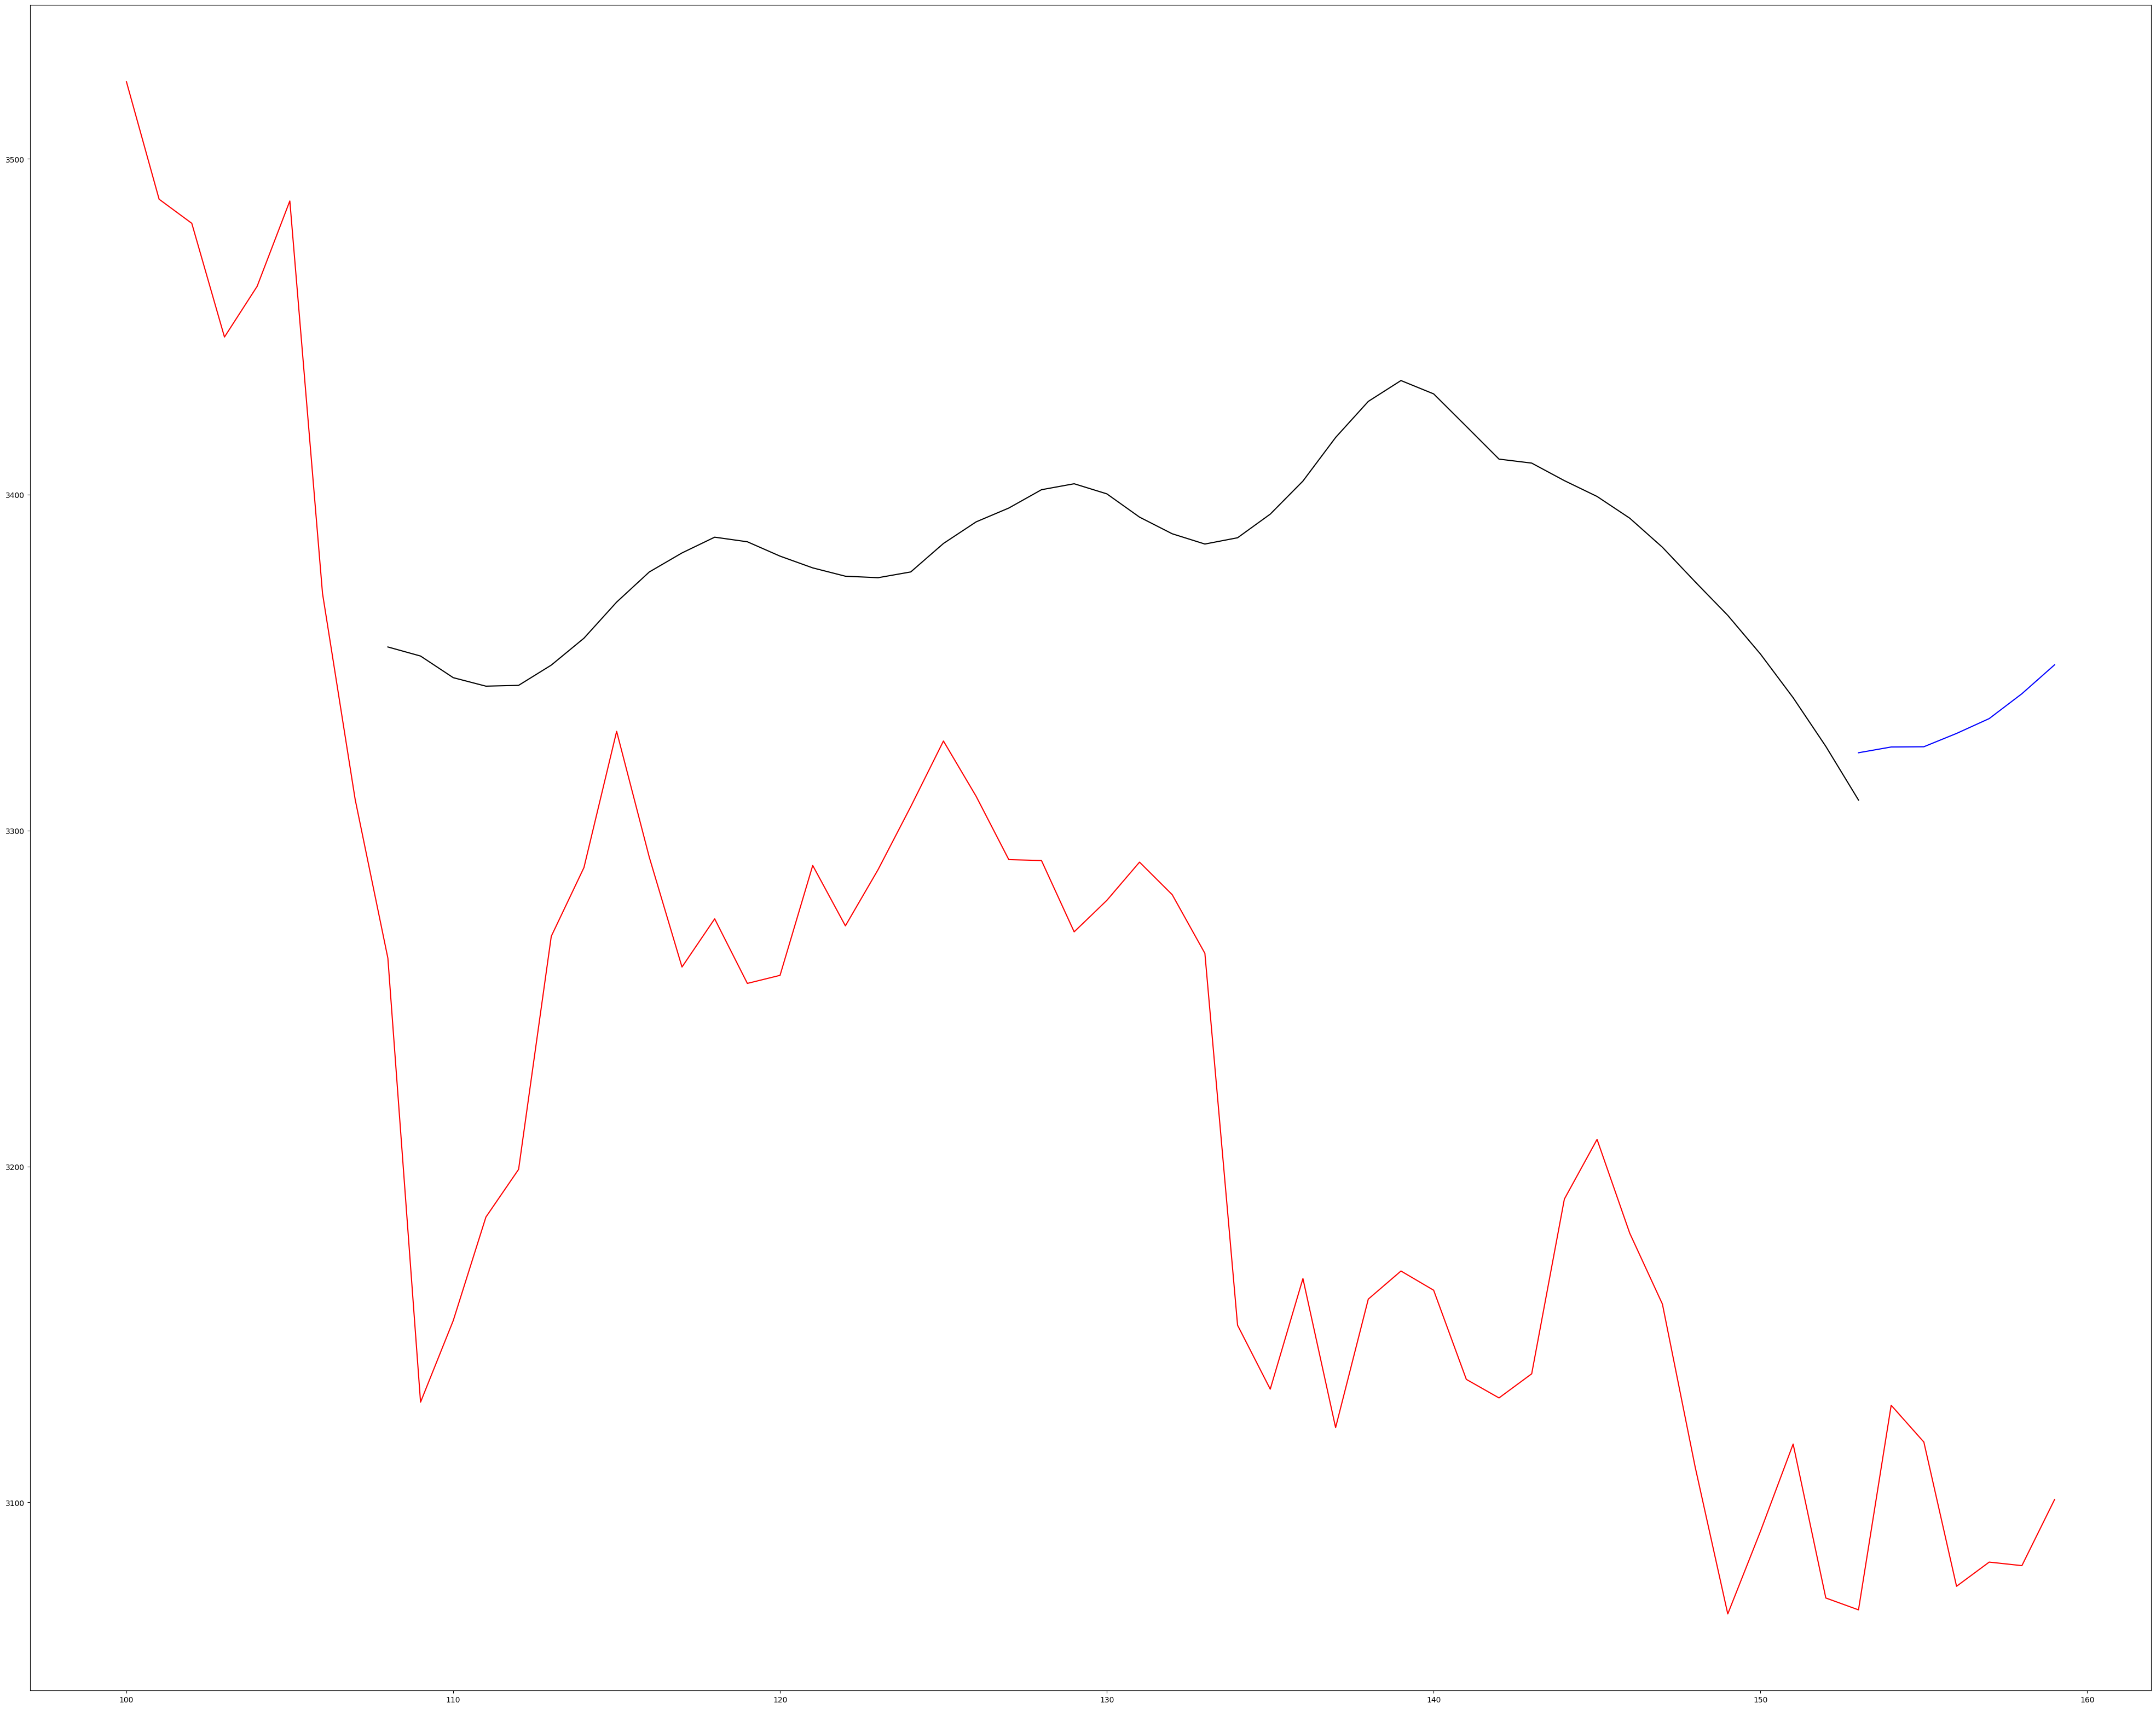

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 40))

t = 100

plt.plot(data_backup.index[t+53:t+60], savgol_predictions_test[0][0], color='blue')
plt.plot(data_backup.index[t+8:t+54], savgol_cropped_test[0], color='black')
plt.plot(data_backup.index[t:t+60], data_backup['close'].iloc[t:t+60], color='red')